# Дорогой дневник

--------------------------------------------

1) Сначала я решил попробовать без генерации новых фичей и без подкрутки параметров запустить LightGBM и посмотреть, что будет. Скор 0.720
При этом пока еще нет ни генерации новых признаков, ни использования таблицы поиска и тд. Попробуем добавить.

2) Просто запускаем код из "baseline_1_pandas.ipynb" и получаем обещаный скор 0.817

3) Оптюнил 10 минут, безрезультатно. Буду придумывать новые признаки. Думаю начать с кластеризации и knn. 

4) Сначала решил просто расширить плавающее окно с 4 до 5 месяцев, результат 0.8192.

    Есть огромное количество идей, только что заменил пандас на поларс, потому что он реально на порядок быстрее. В первую очередь хочется применить знания с семинара по интерпретации бустингов, но сначала заменить катбуст на lgbm, ибо Илья утверждал, что при должном обращении он рвет и мечет.

5) Провел маштабное расследование в данных. Сначала просто обучил lgbm со скором примерно 0.817 и применил на нам всю информацию из семинара про интерпретацию бустингов. Пока что не совсем понятно как это оформиать и как интерпретировать некотрые вещи, но что точно ясно это то, что модель досточно устойчива и надежна, она не реазирует на теневые фичи, а это значит что местами можно делать бред не боясь за последствия. Например сделать полиномиальные фичи - всео со всеми. 

6) Это я и сделал, вмете с новыми фиками добавил количество поисков на последний месяц и неделю. Паралельно с этим убрад один выбрас user_id = 2346229. У человека были абсолютно неадекватные значения. Есть еще большое количество таких людей, но у них значения не такие радикальные и я боюсь что они могут оказаться просто очень активными пользователями, выкидывать их значит лишать себя бесценной информации. После добавления пачуи полиномиальных фичей скор стал 0.8210. Дальше планирую применить кластеризацию на поиске и заказах. Мне кажется очень логичным, что если человек совершал покупки одной категории, то он вероятнее купит еще, чем другой человек с та4ким же числом покупок, но разных категорий. 

7) Кластеризация. Очень долго ей занимался, сейчас подведу итоги всех трех дней. Главная идея такая - модель уже использует агригаты, так что для того чтобы повысить качество нужно использовать какую то иную информацию. Первое что проходит на ум - запросы человека. Банально провести кластеризацию на запросах и потом построить на этих метках новые агрегаты. Но есть проблема, у нас 77кк строк запросов и даже если написать нормальный алгоритм это будет работать 19 часов. Помимо того на сэмпле и понижении размерности через PCA выяснилось, что данные это полосы, крупные классы запиывают мелкие и те забиваются одной неразделимой кучей в углу, не получается чегото адекватного даже если использовать гауссовскую кластеризациюд или GMM. 300к обьектов обрабатывались несколько минут и я решил сделать кластеризацию полуавтоматически. Я создал столбец 'cluster' и заполнил его -1. Построив кластеризацию на 10_000 обьектах выделил некоторые классы, они ясно выделаются, например 20-30 обьектов с словом "вода" в названии, и заполнил их метки руками. Потом снова построил кластеризацию на оставшихся. Леноточная структура осталась, но обьекты былит уже другими. за каждую такую итерацию отсеивалось от 3кк до 10кк обьектов. Итого у меня определилось 18 кластеров - напитки, питомцы, мясо и многое другое. В итоге еще осталось 23кк обьектов, но там очень сложно выделить группы. В принципе я могу свести их до 10кк, но вопрос есть ли в этом смысл. После таких не простых манипуляций мы получаем метки, но это просто инструмент. То что реально даст прирост качества это агрегаты. Не просто было придумать их и не все оказались удачными. Я добавил последний доминирующий кластер, концентрация интересов, переключения между кластерами, стабильность кластеров, время в основном кластере, среднее время между сменами кластеров, средняя длина запроса, разница длины запросов. В итоге скор получился 0.8221.

8) Итак, начинаем агрегацию через knn, начальный скор без поли фичей и кластеризации по поиску - 0.8208
9) Косле knn скор 0.8209, нет особо смысла это делать при таких условиях, потому что я данных много пропусков. Вернее в тех столбцах, на которых запускал я много пропусков, нужно было попробовать меньшее количество столбцов, но сейчас я хочу в отдельном файле сконцентрораваться на генерации признаков, их трансформации и кодирвоании. 
10) Начало генерации фичей - скор 0.8210. Смешно что он выше чем при knn.

--------------------------------------------

--------------------------------------------

In [1]:
import polars as pl
import pandas as pd
import numpy as np
import catboost
import os
from datetime import date, timedelta
from itertools import combinations

from local_utils import *
import lightgbm as lgb

%load_ext autoreload
%autoreload 2


In [2]:
test_start_date = date(2024, 8, 1)
val_start_date = date(2024, 7, 1)
val_end_date = date(2024, 7, 31)
train_end_date = date(2024, 6, 30)
data_path = "C:\\Users\\Admin\\Desktop\\AIM 2сем\\ML2\\hw2"

In [3]:
actions_history = pl.scan_parquet(os.path.join(data_path, 'actions_history/*.parquet')).collect()
search_history = pl.scan_parquet(os.path.join(data_path, 'search_history/*.parquet')).collect()
product_information = pl.read_csv(
    os.path.join(data_path, 'product_information.csv'),
    ignore_errors=True
)

In [4]:
val_target = (
    actions_history
    .filter(pl.col('timestamp').dt.date() >= val_start_date)
    .filter(pl.col('timestamp').dt.date() <= val_end_date)
    .select('user_id', (pl.col('action_type_id') == 3).alias('has_order'))
    .group_by('user_id')
    .agg(pl.max('has_order').cast(pl.Int32).alias('target'))
)

In [5]:
val_target.group_by('target').agg(pl.count('user_id'))

target,user_id
i32,u32
0,1227381
1,647575


In [6]:
actions_aggs = {}
actions_id_to_suf = {
    1: "click",
    2: "favorite", 
    3: "order",
    5: "to_cart",
}

all_aggs = []
numeric_features = []

for id_, suf in actions_id_to_suf.items():
    aggs = (
        actions_history
        .filter(pl.col('timestamp').dt.date() <= train_end_date)
        .filter(pl.col('timestamp').dt.date() >= train_end_date - timedelta(days=30 * 4))
        .filter(pl.col('action_type_id') == id_)
        .join(
            product_information.select('product_id', 'discount_price'),
            on='product_id',
        )
        .group_by('user_id')
        .agg(
            pl.count('product_id').cast(pl.Int32).alias(f'num_products_{suf}'),
            pl.sum('discount_price').cast(pl.Float32).alias(f'sum_discount_price_{suf}'),
            pl.max('discount_price').cast(pl.Float32).alias(f'max_discount_price_{suf}'),
            pl.max('timestamp').alias(f'last_{suf}_time'),
            pl.min('timestamp').alias(f'first_{suf}_time'),
        )
        .with_columns([
            (pl.lit(val_start_date) - pl.col(f'last_{suf}_time'))
            .dt.total_days()
            .cast(pl.Int32)
            .alias(f'days_since_last_{suf}'),
            
            (pl.lit(val_start_date) - pl.col(f'first_{suf}_time'))
            .dt.total_days()
            .cast(pl.Int32)
            .alias(f'days_since_first_{suf}'),
        ])
    )
    
    numeric_features.extend([
        f'num_products_{suf}',
        f'sum_discount_price_{suf}', 
        f'max_discount_price_{suf}',
        f'days_since_last_{suf}',
        f'days_since_first_{suf}',
    ])
    
    actions_aggs[id_] = aggs
    all_aggs.append(aggs)

combined = all_aggs[0]
for i, agg in enumerate(all_aggs[1:], 1):
    combined = combined.join(
        agg, 
        on='user_id', 
        how='left',
        suffix=f"_{i}"
    )

In [7]:
# search_aggs
id_ = 4
suf = 'search'

actions_aggs[id_] = (
    search_history
    .filter(pl.col('action_type_id') == id_)
    .filter(pl.col('timestamp').dt.date() <= train_end_date)
    .filter(pl.col('timestamp').dt.date() >= train_end_date - timedelta(days=30 * 5))
    .group_by('user_id')
    .agg(
        # Общее количество поисков за 5 месяцев
        pl.count('search_query').cast(pl.Int32).alias(f'num_{suf}'),
        pl.col('search_query').n_unique().alias(f'unique_{suf}_queries'),
        
        # Количество поисков за последний месяц (30 дней)
        pl.col('search_query')
            .filter(pl.col('timestamp').dt.date() >= train_end_date - timedelta(days=30))
            .count()
            .cast(pl.Int32)
            .alias(f'num_{suf}_last_month'),
        
        # Количество поисков за последнюю неделю (7 дней)
        pl.col('search_query')
            .filter(pl.col('timestamp').dt.date() >= train_end_date - timedelta(days=7))
            .count()
            .cast(pl.Int32)
            .alias(f'num_{suf}_last_week'),

        pl.max('timestamp').alias(f'last_{suf}_time'),
        pl.min('timestamp').alias(f'first_{suf}_time'),
    )
    .with_columns([
        (pl.lit(val_start_date) - pl.col(f'last_{suf}_time'))
            .dt.total_days()
            .cast(pl.Int32)
            .alias(f'days_since_last_{suf}'),

        (pl.lit(val_start_date) - pl.col(f'first_{suf}_time'))
            .dt.total_days()
            .cast(pl.Int32)
            .alias(f'days_since_first_{suf}'),
    ])
    .select(
        'user_id',
        f'num_{suf}',
        f'unique_{suf}_queries',
        f'num_{suf}_last_month',
        f'num_{suf}_last_week',
        f'days_since_last_{suf}',
        f'days_since_first_{suf}',
        f'last_{suf}_time',
        f'first_{suf}_time',
    )
)

In [8]:
df_main = val_target
for _, actions_aggs_df in actions_aggs.items():
    df_main = (
        df_main
        .join(actions_aggs_df, on='user_id', how='left')
    )
    
df_pd = df_main.to_pandas()

num_cols = ['num_products_click', 'sum_discount_price_click', 'max_discount_price_click', 'days_since_last_click', 'days_since_first_click', 
    'num_products_favorite', 'sum_discount_price_favorite', 'max_discount_price_favorite', 'days_since_last_favorite', 
    'days_since_first_favorite', 'num_products_order', 'sum_discount_price_order', 'max_discount_price_order', 'days_since_last_order', 
    'days_since_first_order', 'num_products_to_cart', 'sum_discount_price_to_cart', 'max_discount_price_to_cart', 'days_since_last_to_cart', 
    'days_since_first_to_cart']

In [9]:
from local_utils import *

df_pd = df_pd[df_pd['user_id'] != 2346229]

cols = [
    # Существующие столбцы
    'num_products_click', 
    'sum_discount_price_click', 'max_discount_price_click',
    'days_since_last_click', 'days_since_first_click',
    'num_products_favorite', 'sum_discount_price_favorite',
    'max_discount_price_favorite', 'days_since_last_favorite',
    'days_since_first_favorite', 'num_products_order',
    'sum_discount_price_order', 'max_discount_price_order',
    'days_since_last_order', 'days_since_first_order',
    'num_products_to_cart', 'sum_discount_price_to_cart',
    'max_discount_price_to_cart', 'days_since_last_to_cart',
    'days_since_first_to_cart', 'num_search', 'days_since_last_search',
    'days_since_first_search', 
]

In [10]:
tr, val = get_split(df_pd, val_size=0.3)

In [11]:
params={
        'objective': 'binary',
        'metric': 'auc',
        'learning_rate': 0.01,
        'max_depth': 100,
        'num_iterations': 700,
        'early_stopping_rounds': 60,
        'verbose': 1,
        'importance_type': 'split'
    }

model = train_model(tr, val, cols, 'target', params=params, shadow_features=False, sklearn_style=True)

[LightGBM] [Warning] early_stopping_round is set=60, early_stopping_rounds=60 will be ignored. Current value: early_stopping_round=60
[LightGBM] [Info] Number of positive: 453459, number of negative: 859009
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.022952 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 4420
[LightGBM] [Info] Number of data points in the train set: 1312468, number of used features: 23
[LightGBM] [Warning] early_stopping_round is set=60, early_stopping_rounds=60 will be ignored. Current value: early_stopping_round=60
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.345501 -> initscore=-0.638875
[LightGBM] [Info] Start training from score -0.638875
Training until validation scores don't improve for 60 rounds
Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:

feature_importance: [2115  576  581  739  437  476  104  331  134  279 1300 1460  680 1714
 2111 1440 1278  537  780  871 1303  779  855] 



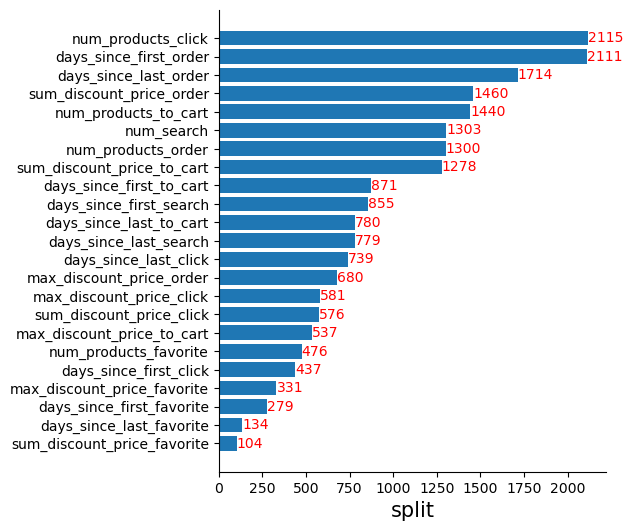

In [12]:
from local_utils import *

print('feature_importance:', model.feature_importances_, '\n')

plot_lgbm_importance(model, cols, importance_type='split', top_k=30, sklearn_style=True)

test_users_submission = (
    pl.read_csv(os.path.join(data_path, 'test_users.csv'))
)

In [13]:
actions_aggs = {}
actions_id_to_suf = {
    1: "click",
    2: "favorite", 
    3: "order",
    5: "to_cart",
}

# Сначала соберем все агрегированные данные
all_aggs = []
numeric_features = []

for id_, suf in actions_id_to_suf.items():
    aggs = (
        actions_history
        .filter(pl.col('timestamp').dt.date() <= val_end_date)
        .filter(pl.col('timestamp').dt.date() >= val_end_date - timedelta(days=30 * 5))
        .filter(pl.col('action_type_id') == id_)
        .join(
            product_information.select('product_id', 'discount_price'),
            on='product_id',
        )
        .group_by('user_id')
        .agg(
            pl.count('product_id').cast(pl.Int32).alias(f'num_products_{suf}'),
            pl.sum('discount_price').cast(pl.Float32).alias(f'sum_discount_price_{suf}'),
            pl.max('discount_price').cast(pl.Float32).alias(f'max_discount_price_{suf}'),
            pl.max('timestamp').alias(f'last_{suf}_time'),
            pl.min('timestamp').alias(f'first_{suf}_time'),
        )
        .with_columns([
            (pl.lit(test_start_date) - pl.col(f'last_{suf}_time'))
            .dt.total_days()
            .cast(pl.Int32)
            .alias(f'days_since_last_{suf}'),
            
            (pl.lit(test_start_date) - pl.col(f'first_{suf}_time'))
            .dt.total_days()
            .cast(pl.Int32)
            .alias(f'days_since_first_{suf}'),
        ])
    )
    
    # Сохраняем имена числовых фичей для создания полиномов
    numeric_features.extend([
        f'num_products_{suf}',
        f'sum_discount_price_{suf}', 
        f'max_discount_price_{suf}',
        f'days_since_last_{suf}',
        f'days_since_first_{suf}',
    ])
    
    actions_aggs[id_] = aggs
    all_aggs.append(aggs)

# Объединяем все агрегации по user_id с суффиксами
combined_val = all_aggs[0]
for i, agg in enumerate(all_aggs[1:], 1):
    combined_val = combined_val.join(
        agg, 
        on='user_id', 
        how='outer',
        suffix=f"_{i}"
    )

C:\Users\Admin\AppData\Local\Temp\ipykernel_71208\2116881979.py:59: DeprecationWarning: Use of `how='outer'` should be replaced with `how='full'`.
  combined_val = combined_val.join(


In [14]:
id_ = 4
suf = 'search'


actions_aggs[id_] = (
    search_history
    .filter(pl.col('action_type_id') == id_)
    .filter(pl.col('timestamp').dt.date() <= val_end_date)
    .filter(pl.col('timestamp').dt.date() >= val_end_date - timedelta(days=30 * 5))
    .group_by('user_id')
    .agg(
        pl.count('search_query').cast(pl.Int32).alias(f'num_{suf}'),
        pl.col('search_query').n_unique().alias(f'unique_{suf}_queries'),
        
        # Количество поисков за последний месяц (30 дней)
        pl.col('search_query')
            .filter(pl.col('timestamp').dt.date() >= val_end_date - timedelta(days=30))
            .count()
            .cast(pl.Int32)
            .alias(f'num_{suf}_last_month'),
        
        # Количество поисков за последнюю неделю (7 дней)
        pl.col('search_query')
            .filter(pl.col('timestamp').dt.date() >= val_end_date - timedelta(days=7))
            .count()
            .cast(pl.Int32)
            .alias(f'num_{suf}_last_week'),


        pl.max('timestamp').alias(f'last_{suf}_time'),
        pl.min('timestamp').alias(f'first_{suf}_time'),
    )
    .with_columns([
        (pl.lit(test_start_date) - pl.col(f'last_{suf}_time'))
            .dt.total_days()
            .cast(pl.Int32)
            .alias(f'days_since_last_{suf}'),

        (pl.lit(test_start_date) - pl.col(f'first_{suf}_time'))
            .dt.total_days()
            .cast(pl.Int32)
            .alias(f'days_since_first_{suf}'),
    ])
    .select(
        'user_id',
        f'num_{suf}',
        f'unique_{suf}_queries',
        f'num_{suf}_last_month',
        f'num_{suf}_last_week',
        f'days_since_last_{suf}',
        f'days_since_first_{suf}',
        f'last_{suf}_time',
        f'first_{suf}_time',
    )
)

In [15]:
df_main = test_users_submission
for _, actions_aggs_df in actions_aggs.items():
    df_main = (
        df_main
        .join(actions_aggs_df, on='user_id', how='left')
    )
    
df_pd = df_main.to_pandas()

In [16]:
from local_utils import *

df_pd['predict'] = model.predict_proba(df_pd[cols])[:, 1]

In [17]:
df_pd[['user_id', 'predict']]

,user_id,predict
0,1342,0.163451
1,9852,0.781278
2,10206,0.218752
3,11317,0.217469
4,13289,0.571802
...,...,...
2068419,11157283,0.225249
2068420,11160395,0.154261
2068421,11165052,0.595566
2068422,11168218,0.488178


In [20]:
df_pd[['user_id', 'predict']].to_csv('fe_start.csv', index=False)

In [1]:
import polars as pl
import pandas as pd
import numpy as np
import catboost
import os
from datetime import date, timedelta
from itertools import combinations

from local_utils import *
import lightgbm as lgb

%load_ext autoreload
%autoreload 2

test_start_date = date(2024, 8, 1)
val_start_date = date(2024, 7, 1)
val_end_date = date(2024, 7, 31)
train_end_date = date(2024, 6, 30)
data_path = "C:\\Users\\Admin\\Desktop\\AIM 2сем\\ML2\\hw2"

actions_history = pl.scan_parquet(os.path.join(data_path, 'actions_history/*.parquet')).collect()
search_history = pl.scan_parquet(os.path.join(data_path, 'search_history/*.parquet')).collect()
product_information = pl.read_csv(
    os.path.join(data_path, 'product_information.csv'),
    ignore_errors=True
)

val_target = (
    actions_history
    .filter(pl.col('timestamp').dt.date() >= val_start_date)
    .filter(pl.col('timestamp').dt.date() <= val_end_date)
    .select('user_id', (pl.col('action_type_id') == 3).alias('has_order'))
    .group_by('user_id')
    .agg(pl.max('has_order').cast(pl.Int32).alias('target'))
)

val_target.group_by('target').agg(pl.count('user_id'))

target,user_id
i32,u32
0,1227381
1,647575


In [15]:
from local_utils import *

actions_history = pl.scan_parquet('actions_history/*.parquet').collect()
search_history = pl.scan_parquet('search_history/*.parquet').collect()
# Исправленное чтение данных с обработкой ошибок
product_info = pl.read_csv(
    'product_information.csv',
    ignore_errors=True,  # Игнорировать ошибки парсинга
    try_parse_dates=True,  # Попытаться распознать даты
    null_values=['null', 'NULL', 'NA', 'N/A', '']  # Распознаваемые null-значения
)

widget_info = pl.read_csv(
    'widget_info.csv',
    ignore_errors=True,
    try_parse_dates=True,
    null_values=['null', 'NULL', 'NA', 'N/A', '']
)

test_users_submission = (
    pl.read_csv(os.path.join(data_path, 'test_users.csv'))
)

In [ ]:
# Для валидации
val_features = generate_features(
    actions_history,
    search_history,
    product_info,
    widget_info,
    end_date=train_end_date,
    prediction_date=val_start_date
)

# Для теста
test_features = generate_features(
    actions_history,
    search_history,
    product_info,
    widget_info,
    end_date=val_end_date,
    prediction_date=test_start_date
)

# Объединение с целевой переменной
df_train = val_target.join(val_features, on='user_id', how='left')
df_test = test_users_submission.join(test_features, on='user_id', how='left')

In [19]:
df_train.group_by('target').agg(pl.count('user_id'))

target,user_id
i32,u32
0,1227381
1,647575


In [ ]:
df_train = df_train.to_pandas()
df_test = df_test.to_pandas()

tr, val = get_split(df_pd, val_size=0.3)

In [25]:
cols = list(set(df_train.columns) - {'user_id', 'target'})

In [28]:
params={
        'objective': 'binary',
        'metric': 'auc',
        'learning_rate': 0.01,
        'max_depth': 100,
        'num_iterations': 700,
        'early_stopping_rounds': 60,
        'verbose': 1,
        'importance_type': 'split'
    }

model = train_model(tr, val, cols, 'target', params=params, shadow_features=False, sklearn_style=True)


[LightGBM] [Warning] early_stopping_round is set=60, early_stopping_rounds=60 will be ignored. Current value: early_stopping_round=60
[LightGBM] [Info] Number of positive: 453002, number of negative: 859466
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.076281 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 20324
[LightGBM] [Info] Number of data points in the train set: 1312468, number of used features: 85
[LightGBM] [Warning] early_stopping_round is set=60, early_stopping_rounds=60 will be ignored. Current value: early_stopping_round=60
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.345153 -> initscore=-0.640415
[LightGBM] [Info] Start training from score -0.640415
Training until validation scores don't improve for 60 rounds
Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is

feature_importance: [  41  125  704   43  535  876   79  595  186   85  129   26   23 1233
  164  182  164  304  194   69   15  107   28  108  139  161   14  435
  233  519  626  253  257   72   45   18   70  147  269  120   58   72
  183  567  579   28   68  357  475  154  309  169  116  239   35   63
   56  151   27  150  599   82   57    1  124   28   89 1513  518  147
  178  247   49  264  153   88 1769   46   18    7   68  315  313  414
   34] 



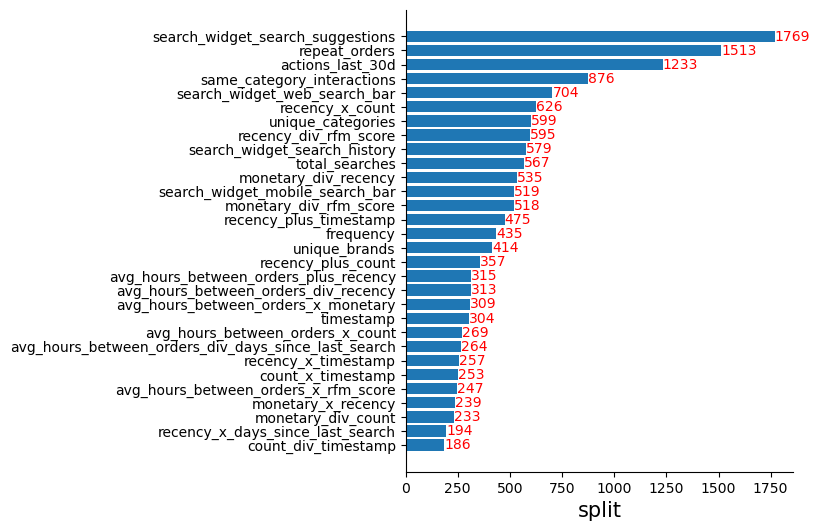

In [29]:
from local_utils import *

print('feature_importance:', model.feature_importances_, '\n')

plot_lgbm_importance(model, cols, importance_type='split', top_k=30, sklearn_style=True)

In [30]:
df_test['predict'] = model.predict_proba(df_test[cols])[:, 1]

In [31]:
df_test[['user_id', 'predict']]

,user_id,predict
0,1342,0.221500
1,9852,0.783697
2,10206,0.221500
3,11317,0.221500
4,13289,0.622858
...,...,...
2068419,11157283,0.221500
2068420,11160395,0.221500
2068421,11165052,0.645976
2068422,11168218,0.451119


In [33]:
df_test[['user_id', 'predict']].to_csv('fe_res.csv', index=False)